### Kernelized Supervised Laplacian Eigenmap of Multi-Label Data
This python code is an implementation of Kernelized Supervised Laplacian Eigenmap for Visualization and Classification of Multi-Label Data published in Pattern Recognition journal. For citation, please use below:

Mariko Tai, Mineichi Kudo, Akira Tanaka, Hideyuki Imai, and Keigo Kimura,
"Kernelized Supervised Laplacian Eigenmap for Visualization and Classification of Multi-Label Data." Pattern Recognition, available online at
https://doi.org/10.1016/j.patcog.2021.108399

First, let's prepare necessary libralies. 

In [1]:
from matplotlib import pyplot as plt
from matplotlib import offsetbox
import numpy as np
import sys
import math
import scipy.linalg
from numpy import linalg as LA
from sklearn.metrics import pairwise

from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components

from sklearn import datasets
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.base import BaseEstimator
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding

from scipy.sparse import csr_matrix, isspmatrix
from matplotlib.colors import LinearSegmentedColormap    #
import random
from sklearn.metrics import classification_report, accuracy_score


The following is main body.

In [2]:
class KSLE_ML():
    def __init__(self, n_components=2, affinity="nearest_neighbors",
                 random_state=None, eigen_solver=None,
                 n_neighbors=None, kernel=None, kopt1=None, n_jobs=1, la=None):
        self.n_components = n_components
        self.affinity = affinity
        self.random_state = random_state
        self.eigen_solver = eigen_solver
        self.n_neighbors = n_neighbors
        #print(n_neighbors)
        self.n_jobs = n_jobs
        self.la = la
 
        # Kernel selection with option
        self.kernel = kernel
        self.kopt1 = kopt1

    @property
    def _pairwise(self):
        return self.affinity == "precomputed"

    def _change_kernel(self, kernel, kopt1=None, setonly =False):
        self.kernel = kernel
        self.kopt1 = kopt1
        ans = True
        if setonly == False:
            G = self._calc_kernel(self.X, self.X)
            self.G = G

            # Solve linear equation GC = Z instead of C = G^{-1}Z 
            rank = np.linalg.matrix_rank(G)
            print('Rank of G is '+str(rank))

            try:
                self.C = np.linalg.solve(G, self.Z)
            except np.linalg.LinAlgError as e:
                if 'Singular matrix' in str(e):
                        exit()
            ans = (rank==self.X.shape[0])
            print('(change)self.C.shape = '+str(self.C.shape)+' rank test='+str(ans))
        return ans

    def _calc_kernel(self, X, Y=None):
        print('Used kernel = ' + self.kernel + " w opt1 = "+ str(self.kopt1))
        if self.kernel == "polynomial":
            k  = pairwise.polynomial_kernel(X, Y, degree=self.kopt1)
        elif self.kernel == "rbf":
            k  = pairwise.rbf_kernel(X, Y, gamma=self.kopt1)
        elif self.kernel == "sinc":
            k  = sinc_kernel(X, Y, alpha=self.kopt1)

        if X.shape == Y.shape:
            print ('Gram matrix was (re)calculated.')
            self.G = k
        return k

    def explicit_map(self,Y):
        C = self.C                           # coefficients of kernels
        print('(exp)self.C.shape = '+str(self.C.shape))
        k = self._calc_kernel(self.X,Y)      # innerproduct to the training sample via kernel
        Z =  np.dot(C.T,k)
        print('(exp) Z.shape = '+str(Z.shape)+' C= '+str(C.shape)+' k= '+str(k.shape))
        return  Z

    def _get_affinity_matrix(self, X, Y=None):
        self.X = X
        print('=== self.X was set in get_affinity')
        length=X.shape[0]
        la = self.la
      
        n = self.n_neighbors
        dist = np.zeros(length*length).reshape((length,length))

        print('In n_nearest: n=%d la=%f len=%d' % (n, la, length))

        N = np.zeros(length*length).reshape((length,length))
        nn = NearestNeighbors(n_neighbors=n+1)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)
        self.distances = distances
        self.indices = indices

        for i in range(length):
            for j in indices[i][1:n]:  # indices[i][0]=i itself
                N[i][j] = 1            # 1 if j is i's one of k NN's

        w_F = weight = (N + N.T)*0.5 #return 0,1 or 0.5

        for i in range(length):
            for j in range(length):

                A = len(np.intersect1d(Y[i],Y[j])) 
                B = len(np.union1d(Y[i],Y[j])) 
                w_L = float(A)/float(B)
                weight[i][j] = la*w_F[i][j] + (1-la)*w_L
                if i==j:
                    weight[i][j]=0.0

        self.affinity_matrix_ = weight
        return self.affinity_matrix_


    def get_parameter(self):  # depends on the kernel to be used
        distances = self.distances
        indices = self.indices
        n = self.X

        print('k = ' + str(self.n_neighbors))
        print('n = ' + str(self.X.shape[0]))

        # In case of RBF kernel, estimate a variance parameter from data
        alpha = np.sum (np.sum(np.power(distances,2), axis=1)/self.n_neighbors) / self.X.shape[0]
        print('alpha = ' + str(alpha))
        return alpha



    def fit(self, X, y=None):
        W = self._get_affinity_matrix(X,y)             # W: similarity matrix
        W_col_sum = np.sum(W, axis=1)
        n = X.shape[0]    # number of samples

        Dmhalf = np.zeros(n*n).reshape((n,n))
        for i in range(n):
            Dmhalf[i][i] = 1.0/np.sqrt(W_col_sum[i])  # D^-1/2

        DWD = np.dot(np.dot(Dmhalf,W),Dmhalf)                       # D^{-1/2}WD^{-1/2}

        Lambda,U = scipy.linalg.eigh(DWD,eigvals=(n-3,n-1))  # Spectral Decomposition

        #print('eigen decomposition')
        #print('Shape - Lambda ' + str(Lambda.shape) + ' U ' + str(U.shape))

        Lambda = Lambda[::-1]   # Choose from the largest eigenvalues except for the largest
        #print(Lambda)
        U = U[:,::-1]
        #print(U)
        sq_U = np.dot(U.T,U)
        #print(sq_U)

        Z = np.dot(Dmhalf,U)                                   # mapped points

        print('eigen_vector (top 10)')
        print(Z[:10])

        Z=Z[:,1:3]  # This is for 2D display. Increase 3 to any number for dimension reduction

        # direction alightment of eigen vectors w.r.t. class 0
        clz_index = (y==0)
        clz_size = np.sum(clz_index)
        valid_index = np.vstack((clz_index,clz_index))
        valid_index =  valid_index.T
        Xz = Z[valid_index]
        Xz = Xz.reshape(clz_size,2)
        Xsum = np.sum(Xz,axis=0)
        Strans = np.identity(2)
        if Xsum[0] < 0:
            Strans[0,0]=-1
        if Xsum[1] < 0:
            Strans[1,1]=-1
        print(Strans)
        Z = np.dot(Z,Strans)

        self.Z = Z
        self.embedding = Z.T
        return self


    def fit_transform(self, X, y=None):
        self.fit(X,y)
        return self.embedding

    def return_C(self):
        C = self.C
        return C


Default kernel is an RBF kernel. Sinc kernel is made ready here in case you need another.  

In [3]:
def sinc_kernel(X,Y,alpha=1.0):             # sin(\alpha \|X-Y\|)/(pi \alpha \|X-Y\|)
    nx = X.shape[0]
    mx = X.shape[1]
    ny = Y.shape[0]
    my = Y.shape[1]
    print('(Sigmoid-Kernel ) nx ='+str(nx)+' mx='+str(mx)+' ny='+str(ny)+' my='+str(my)+' alpha='+str(alpha))
    if mx != my:
        print('nx ='+str(nx)+' mx='+str(mx)+' ny='+str(ny)+' my='+str(my))
        exit
    A = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            nxy = np.linalg.norm(X[i,:]-Y[j,:])

            if nxy == 0.0:
                ans = 1.0/math.pi
            else:
                ans = math.sin(alpha*nxy)/(math.pi*alpha*nxy)
            A[i,j]=ans
    return A


Below is for setting a color map.

In [4]:
def generate_cmap(colors):

    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

Now we are ready to describe Supervised Laplacian Eigenmap for Multi-label datasets (SLE-ML) and its kernelized version (KSLE-ML). First we call SLE to obtain the mapped data in 2D where the parameter $la$ is the degree at which  label information is taken into consideration in addition feature information, $t$ is the parameter of a chosen kernel and $kernel$ is the kernel. For execution, $fit\_transform$ function should be called with feature information $X$ and labal information $y$. For mapping unknown data, we call $explicit\_map$ with a testing dataset $X$. 

In [5]:
def SLE(X,Y,la=0.3): # defaul value of lambda is 0.3 to 0.4; no kernel is necessary for SLE 

    n_classes = len(np.unique(Y))
    n_samples = X.shape[0]
    print("n_classes:",n_classes, "n_samples:",n_samples)
    
    n_neighbors = int(1.5*n_samples/n_classes)   # 1.5 times of average sample number / class

    manifolder = KSLE_ML(n_neighbors=n_neighbors, la=la, kernel="rbf")

    # Supervised Laplacian Eigenmap -> Find the mapped points
    X_transformed = manifolder.fit_transform(X,Y) 
    
    return X_transformed, manifolder

def KSLE(X, manifolder, name):        # realize SLE by a kernel and map testing samples
    
    # mean variance using k-NN of each data in the original space
    kernel_parameter = 1. / manifolder.get_parameter()
    opt = 1.0 * kernel_parameter
    
    f=manifolder._change_kernel(name,opt) 
    
    X_transformed = manifolder.explicit_map(X) 
    
    return X_transformed

In [6]:
import seaborn as sns
def dataset():
    ####Iris
    #'''
    d_name = "Iris" # n_samples 150  n_features 4 n_class =3
    iris = sns.load_dataset('iris')
    X = iris.values[:,:4]
    #X = np.loadtxt('iris.data',dtype='float')  # if you have a text data 
    n_samples, n_features = X.shape
    print("X.shape",X.shape)
    z = np.arange(n_samples)
    z[0:50]=0
    z[50:100]=1
    z[100:150]=2
    y = list(range(n_samples))
    y = z
    n_class = 3
    #'''

    ####digit
    '''
    d_name = "Digit"  
    
    dataset = datasets.load_digits() # n_samples 1797  n_features 64 n_class =10
    X = dataset.data
    y = dataset.target
    n_samples, n_features = X.shape
    print("Original data: n_samples", n_samples, " n_features", n_features)
    n_class = 10
    '''

    ## sample selection
    n_sel_samples = 200           # define a smaller number of samples than that of dataset if you need testing
    # sample selection
    random.seed(0)
    id_all = np.random.choice(n_samples,n_samples,replace=False)
    id_train = id_all[0:n_sel_samples]
    id_test  = id_all[n_sel_samples:]

    #print("id_train:",id_train)
    #print("id_test:",id_test)

    X_train = X[id_train]
    Y_train = y[id_train]
    X_test = X[id_test]
    Y_test = y[id_test]
    
    n_samples, n_features = X_train.shape
    print("#training=",X_train.shape[0]," #testing=",X_test.shape[0]," Dimensionality=",n_features)
    return X_train, Y_train, X_test, Y_test
#dataset()  


Last let's display the mapped training and testing data.

In [7]:
def two_d_display(Z,Y,ssize=25,smark="o",xdmin=0.0,xdmax=0.0,ydmin=0.0,ydmax=0.0):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    if (xdmin != 0.0):
        plt.xlim(xdmin,xdmax)          
        plt.ylim(ydmin,ydmax)
    
    n_classes = len(np.unique(Y))
    
    # only three cases are made ready
    if n_classes == 2:
        cm = generate_cmap(['blue','red'])
    elif n_classes == 3:
        cm = generate_cmap(['orange','green','red'])
    elif n_classes == 10:
        cm = generate_cmap(['mediumblue','aqua','orange','black','red','yellow','purple','pink','green','grey'])

    plt.scatter(Z[0,:], Z[1,:], s=ssize, marker=smark, c=Y, cmap=cm, edgecolors="black") 

    plt.show()

    xdmin, xdmax = ax.get_xlim()
    ydmin, ydmax = ax.get_ylim()
    
    return xdmin,xdmax,ydmin,ydmax

OK. Everything is ready. Try below.

X.shape (150, 4)
#training= 150  #testing= 0  Dimensionality= 4
n_classes: 3 n_samples: 150
=== self.X was set in get_affinity
In n_nearest: n=75 la=0.300000 len=150
eigen_vector (top 10)
[[-0.0108627  -0.01548605 -0.00437212]
 [-0.0108627   0.01104432 -0.0131677 ]
 [-0.0108627  -0.01551909 -0.00444921]
 [-0.0108627  -0.01552671 -0.00444518]
 [-0.0108627   0.01114627 -0.01376932]
 [-0.0108627   0.01117511 -0.01396624]
 [-0.0108627  -0.01550857 -0.00445536]
 [-0.0108627   0.0021625   0.01458861]
 [-0.0108627   0.0029904   0.01200111]
 [-0.0108627   0.00373991  0.01215307]]
[[-1.  0.]
 [ 0. -1.]]
Transformed training data size (2, 150)


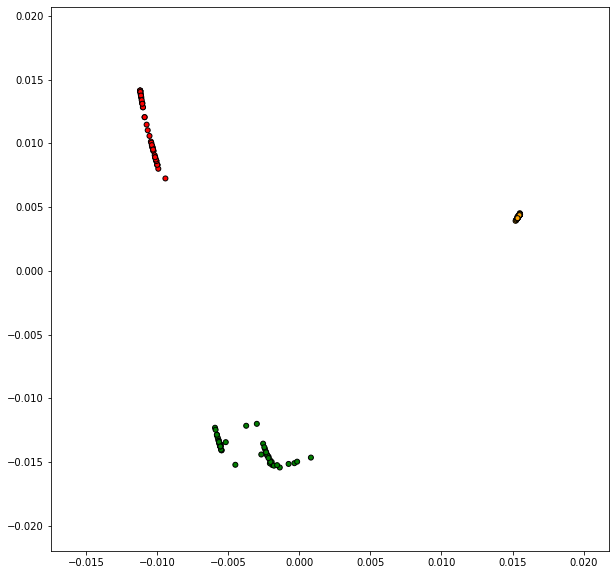

In [14]:
X_train,Y_train,X_test,Y_test =dataset()

# Execute Supervised Laplacian Eigenmap

Z_train,manifolder= SLE(X_train,Y_train,la=0.3)     # specify the value of la (0.0=Label only, 1.0=Feature only)
                                                    # if you want an other value than the default 0.3
print("Transformed training data size",Z_train.shape)
#print("Transformed training data\n",Z_train)
xdmin,xdmax,ydmin,ydmax=two_d_display(Z_train,Y_train)

# Execute Explict Kernelized SLE
if X_test.shape[0] > 0: 
    Z_test=KSLE(X_test,manifolder, "rbf")
    print("Transformed testing data size",Z_test.shape)
    #print("Transformed testing data\n",Z_test)
    two_d_display(Z_test,Y_test,ssize=150,smark="*",xdmin=xdmin,xdmax=xdmax,ydmin=ydmin,ydmax=ydmax)

(Option) Last, let's classify testing samples in the mapped space. Here, we use a nearst centroid classifier.

In [9]:
def NCC_assifier(Z_tr, Y_tr, Z_te, Y_te):
        #Nearest Centroid Classifier appliced in the mapped space
        test = Z_te.T
        train = Z_tr.T
        print(test)
        print("Training:",train.shape)
        print("Testing :",test.shape)
        n_classes = len(np.unique(Y_tr))
        print("#classes:",n_classes)
        
        CLF = np.arange(n_classes+1,dtype=float)
        CLF[10] = 0.0

        #Nearest Centroid Classifier
        print("-Nearest Centroid Classifier-")
        clf = NearestCentroid()
        clf.fit(train, Y_tr)
        y_pred = np.copy(clf.predict(test))

        TorF = np.zeros(test.shape[0])
        for n in range(test.shape[0]):
            if Y_te[n] == y_pred[n]:
                TorF[n] = 1
        TorF_sum = np.sum(TorF,dtype=float)
        print("TorF:",TorF)
        CCLF = np.copy(float(TorF_sum)/float(test.shape[0]))

        CLF[0] = np.copy(accuracy_score(Y_test, y_pred))
        print('accuracy_score = '+ str(CLF[0]))
        print('CLF = ' + str(CCLF))


In [10]:
NCC_assifier(Z_train,Y_train,Z_test,Y_test)

NameError: name 'Z_test' is not defined